What IonSim does

IonSim is built around [QuantumOptics.jl](https://qojulia.org/) and is primarily intended to simulate the following general system:

---
<img src="trapped_ion_system.png" align="center"/>

---

Whose corresponding Hamiltonian (in an appropriate rotating frame) is given by:

![](hamiltonian_equation.png)

Here:
+ $\Omega_{nm} \cdot g(m, k_n, j_n)$ describes the coupling between the $m^{th}$ laser and the $n^{th}$ ion's $|k_n\rangle \leftrightarrow | j_n \rangle$ transition -- $\Omega_{nm}$ depends on the intensity of the laser at the ion's position and $g$ is a geometric factor that depends on the details of the laser and transition.
+ $\bar{\Delta}_{nmk_nj_n}$ is the average detuning of the m$^{th}$ laser from $|k_n\rangle \leftrightarrow | j_n \rangle$.
+ $\hat{\sigma}_{n,k_n,j_n} = |k_n\rangle\langle j_n|$


---
To enable the simulation, IonSim performs two main tasks:
1. Keeps track of the parameters and structure of the Hamiltonian according to user inputs
2. Given these inputs, constructs a function that efficiently returns the numerical representation of the Hamiltonian as a function of time.

The Hamiltonian function can then be used as input to one of the various **QuantumOptics.jl** differential equation solvers.

---
**1)** is accomplished with the use of Julia [`structs`](https://docs.julialang.org/en/v1/manual/types/). 

For reference, a map of these `structs` and their relationships is shown below.

![](graph.png)
<!-- <img src="graph.png"  width=1000 height=1000 align="center"/> -->

---
**2)** is mainly handled in [hamiltonians.jl]().

---

# How it works

We'll demonstrate the basics by walking you through some simple examples.

## Load necessary modules

---
When starting a new notebook, the first thing we have to do is load in the relevant modules.

*Note: loading modules can be slow in Julia. The same is true when running a function for the first time. This has to do with precompilation, see [here](https://stackoverflow.com/questions/47501844/julia-differentialequations-jl-speed) or [here](https://discourse.julialang.org/t/ways-to-make-slow-sluggish-repl-interactive-development-experience-faster/25293) for more details. One workaround is to just keep notebooks running as long as possible, but you can also look into creating a sysimage with [PackageCompiler.jl](https://github.com/JuliaLang/PackageCompiler.jla).*

In [3]:
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic

---
We'll also load PyPlot (an interface to Python's matplotlib), which we'll need later

In [4]:
import PyPlot
const plt = PyPlot
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

## Setting up the system

First we'll create an ion:

In [5]:
C = Ca40(["S-1/2", "D-1/2"])
print(typeof(C) <: Ion)

true

---
`Ca40` is a composite type derived from the abstract type `Ion` (as demonstrated in the second line). By giving the argument `["S-1/2", "D-1/2"]` we've decided to only pay attention to these two electronic levels.

To see all of the options for `Ca40` we can look at its doc string, which can be accessed in Julia by typing `?` before the variable name:

In [6]:
?Ca40

search: Ca40



```
Ca40(selected_level_structure::Vector{String}[, stark_shift])
```

#### user-defined fields

  * `selected_level_structure`:    keys ⊂ `["S-1/2", "S+1/2", "D-5/2", "D-3/2", "D-1/2", "D+1/2", "D+3/2", "D+5/2"]`.   Values are a `NamedTuple` with:

      * `l`: orbital angular momentum
      * `j`: total angular momentum
      * `mⱼ`: projection of total angular momentum along quantization axis
      * `E`: relative energies

    Note: indexing the instantiated structure with one of these strings will return    the corresponding `Ket`.
  * `stark_shift`: A dictionary with keys denoting the selected levels and values, a real    number for describing a shift of the level's energy. This is just a convenient way to add    Stark shifts to the simulation without additional resources.

#### fixed fields

  * `mass::Real`: The ion's mass in kg.
  * `level_structure`: A full description of the ion's electronic structure.
  * `matrix_elements::OrderedDict{Tuple,Function}`: Same as `selected_matrix_elements` but for   all of the ion's allowed transitions.

#### derived fields

  * `selected_matrix_elements`: Functions for the allowed transitions (contained in the    selected levels) that return the corresponding coupling strengths. These functions take    as arguments:

      * `Efield`: magnitude of the electric field at the position of the ion [V/m]
      * `γ`: $ϵ̂⋅B̂$ (angle between laser polarization and B-field)
      * `ϕ`: $k̂⋅B̂$ (angle between laser k-vector and B-field)
  * `shape::Vector{Int}`: Indicates the dimension of the used Hilbert space.
  * `number`: When the ion is added to an `IonConfiguration`, this value keeps track of its    order in the chain.
  * `position`: @hen the ion is added to an `IonConfiguration`, this value keeps track of its   physical position in meters.


---
We can also preview the values of the various fields of our instantiated `C` by typing `C.` and pressing the tab key.

---
Next we'll define a laser:

In [9]:
L = Laser();
print(L)

λ: 7.29147e-7 m
Δ: 0 Hz
ϵ̂: (x=0.7071067811865475, y=0.7071067811865475, z=0.0)
k̂: (z=0, y=0, z=1)
E(t=0): 0 V/m
ϕ(t=0): 0 ⋅ 2π


---
As shown, the default wavelength of `Laser` is set to match spin-orbit splitting of the $S_{1/2}$ and $D_{5/2}$ levels of $^{40}$Ca. Again, to view the other attributes for `Laser` take a look at its doc string (or use `L.` + tabkey).

To include the center of mass motion of the ion in our simulation, we need to add it to an `IonConfiguration`:

In [10]:
chain = LinearChain(ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
print(typeof(chain) <: IonConfiguration)

true

---
`LinearChain` automatically computes the normal modes for a collection of ions (as input to keyword argument `ions`) in a linear Coloumb crystal with the given center of mass frequencies. By setting `vibrational_modes=(;z=[1])` (which is the same as `vibrational_modes=(x=[], y=[], z=[1])` or `vibrational_modes=(y=[], z=[1])`) we've decided to only consider the 1st normal mode along the ẑ-direction. *(Note: ẑ is always assumed to be along the crystal's axis of symmetry).*

In [11]:
chain.vibrational_modes

(x = VibrationalMode[], y = VibrationalMode[], z = VibrationalMode[VibrationalMode(ν=1.0e6, axis=ẑ, N=10)])

---
The last thing we need to construct is a `Trap`, which takes all of these objects that we've defined and puts them together:

In [12]:
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

---
A `Trap` specifically associates an `IonConifiguration` and a set of lasers. It keeps track of which lasers point at which ions and with how much scaled strength (to model e.g. crosstalk). It also keeps track of the magnetic field. In this case we've set the magnetic field to have a strength of 4 Gauss and to point in the ẑ-direction. δB can be used to model a time-dependent magnetic field, which for example, might be useful to model noise -- for now we set it to 0.

An important point needs to be made on the ordering of the composite basis, which describes the trap's Hilbert space. Though, mathematically, `C.basis ⊗ configuration.vibrational_modes.z[1].basis` is equivalent to `configuration.vibrational_modes.z[1].basis ⊗ C.basis`, when converted to the space of 2D matrices the description of these two bases will be different. Equivalence is maintained provided that the order is consistent throughout the description of the problem, but this requires us to set a convention. For a trap composed of a linear chain of ions, IonSim's convention is: ion₁ ⊗ ion₂ ⊗ ... ⊗ ionₙ ⊗ mode₁ ⊗ mode₂ ⊗ ... ⊗ modeₙ, where the ion bases are ordered according to the order in `T.configuration.ions` and the vibrational modes are ordered according to the order in `[T.configuration.vibrational_modes.x, T.configuration.vibrational_modes.y, T.configuration.vibrational_modes.z`].

## Simulating basic dynamics

### Carrier Rabi

Let's start off by simulating rabi oscillations between the two defined states of our ion. First we have to update some of the parameters in our system.

Due to selection rules and because we've defined our magnetic field to point in the ẑ-direction we need to update the geometry of our laser to have a nonzero coupling to this transition:

In [13]:
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/lasers.jl:84


---
Since the nonzero magnitude of the Bfield has shifted the Zeeman sublevels we also need to detune the laser. We can do this with the help of the convenience function `transition_frequency`.

*As a side note, we can see a full list of the functions available from IonSim by typing `IonSim.` and pressing the tab key. Functions beginning with an underscore are generally not meant to be accessed interactively. Everything else should have a doc string.*

In [14]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf

2.239399193848153e6

In [85]:
?transition_frequency

search: transition_frequency



```
transition_frequency(
    B::Real, ion::Ion, transition::Union{Tuple{String,String},Vector{<:String}}
)
```

Compute the transition frequency of the `ion`'s selected transition under Bfield `B`. Alternatively, one may use:

```
transition_frequency(
        T::Trap, ion::Ion, transition::Union{Tuple{String,String},Vector{<:String}}
    )
```

which is the same as `transition_frequency(T.B, ion, transition)` or

```
transition_frequency(
        T::Trap, ion_index::Int, transition::Union{Tuple{String,String},Vector{<:String}}
    )
```

which is the same as `transition_frequency(T.B, T.configuration.ions[ion_index], transition)`.


---
Finally, we should set the laser's electric field amplitude (at the position of the ion) to something reasonable. For this we use the convenience function `Efield_from_pi_time!` *(It's customary in Julia to end the names of functions that update their arguments in-place with a "!").*

In [15]:
Efield_from_pi_time!(2e-6, T, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 2 μs

In [16]:
?Efield_from_pi_time

search: Efield_from_pi_time Efield_from_pi_time!



```
Efield_from_pi_time(
    pi_time::Real, Bhat::NamedTuple{(:x,:y,:z)}, laser::Laser, ion::Ion, 
    transition::Union{Tuple{String,String},Vector{<:String}}
)
```

Compute the E-field needed to get a certain `pi_time` with a certain `laser`-`ion`  `transition`.

Alternatively, one may use

```
Efield_from_pi_time(
            pi_time::Real, T::Trap, laser_index::Int, ion_index::Int, 
            transition::Union{Tuple{String,String},Vector{<:String}}
        )
```

which is the same as  `Efield_from_pi_time(pi_time, T.Bhat, T.lasers[laser_index], T.configuration.ions[ion_index], transition)`


---
The last thing we need to do before we run our simulation is to construct the hamiltonian:

In [17]:
?hamiltonian

search: hamiltonian



```
hamiltonian(
        T::Trap; timescale::Real=1e-6, lamb_dicke_order::Union{Vector{Int},Int}=1, 
        rwa_cutoff::Real=Inf, displacement="truncated", time_dependent_eta=false
    )
```

Constructs the Hamiltonian for `T` as a function of time. Return type is a function  `h(t::Real, ψ)` that, itself, returns a `QuantumOptics.SparseOperator`.

#### args

  * `timescale`: e.g. a value of 1e-6 will take time to be in $\mu s$
  * `lamb_dicke_order`: Only consider terms that change the phonon number by up to this value.   If this is an `Int`, then the cutoff is applied to all modes. If this is a `Vector{Int}`,   then `lamb_dicke_order[i]` is applied to the iᵗʰ mode, according to the order in    `T.basis`.   Note: this isn't quite the same thing as the Lamb-Dicke approximation since setting   `lamb_dicke_order=1` will retain, for example, terms proportional to $a^\dagger a$.
  * `rwa_cutoff`: drop terms in the Hamiltonian that oscillate faster than this cutoff.
  * `displacement`: This can be either `"truncated"`(default) or `"analytic"`. 

    When an atom is irradiated, both the atom's energy and its momentum will generally be   affected. For an atom in a harmonic potential, the exchange of momentum can be modeled as   a displacement operation $D(α=iηe^{-iνt}) = exp[αa^† - α^*a]$, where $η$ is the   Lamb-Dicke parameter, which can be described equivalently as either being proportional to   the square root of the ratio of the recoil frequency with the ground state energy of the   atom's motion or as the ratio of the spread of the ground state wavefunction to the   wavelength of the laser.

    When `"truncated"` is selected, the matrix elements of $D(α)$ are computed by   constructing $α^* a, αa^†$ in a truncated basis (according to the dimension specified in   your model) and then exponentiating their difference. This has the advantage, amongst   other things, of guaranting unitarity.

    If `"analytic"` is selected, then the matrix elements are computed assuming an infinite-  dimensional Hilbert space.

    For small displacements ($η ≪ N$, where $N$ is the dimension of the motion's Hilbert  space), both of these methods will be good approximations.
  * `time_dependent_eta::Bool`: In addition to impacting the vibrational subspace directly, a   change in the trap frequency, $δν$, will also change the Lamb-Dicke parameter. Since   typically $δν≪ν$, this effect will be small $η ≈ η₀(1 + δν/2ν)$ and doesn't warrant   the additional computational resources needed to calculate and update it in time. In this   case, we can set `time_dependent_eta=false` (default), which will set $η(t) = η₀$.


In [18]:
h = hamiltonian(T, timescale=1e-6);  # setting timescale=1e-6 sets the units of time to μs

Now we can take `h` and feed it into one of the [`QuantumOptics.timeevolution`](https://qojulia.org/documentation/timeevolution/timeevolution/) solvers:

In [19]:
tspan = 0:0.01:10
mode = T.configuration.vibrational_modes.z[1]
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h);

 10.864052 seconds (36.17 M allocations: 1.901 GiB, 7.13% gc time)


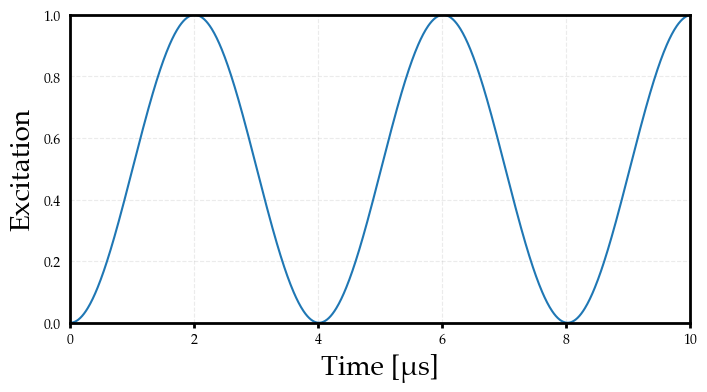

In [20]:
ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

In the above plot, we see Rabi oscillations with a pi-time of 2 μs, as expected.

Now if we add an additional detuning to the laser equal to the Rabi frequency, we should see oscillation with half the amplitude and √2 times the frequency:

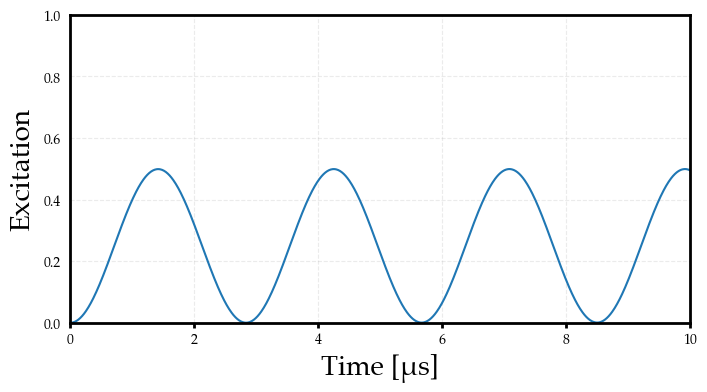

  0.003041 seconds (92.43 k allocations: 3.284 MiB)


In [21]:
L.Δ = Δf + 2.5e5

h = hamiltonian(T, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h)

ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

We can achieve the same effect by instead setting a nonzero value in our ion's `stark_shift` field. This can be useful when we have several ions in our chain and want to simulate a Stark shift without involving an additional laser resource.

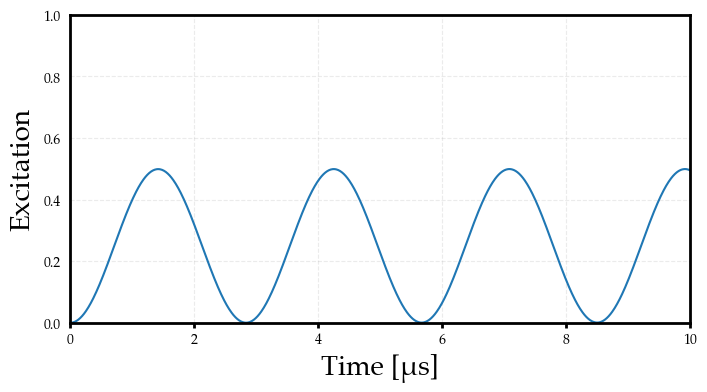

  0.004155 seconds (92.43 k allocations: 3.284 MiB)


In [22]:
L.Δ = Δf

C.stark_shift["S-1/2"] = -1.25e5
C.stark_shift["D-1/2"] = 1.25e5

h = hamiltonian(T, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ mode[0], h)

ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
So far our simulations have used an initial state `ion_state(T, "S-1/2") ⊗ fockstate(mode.basis, 0)`, or $|S_{-1/2}, n=0\rangle$, but we can also start off with the vibrational mode in a thermal state:

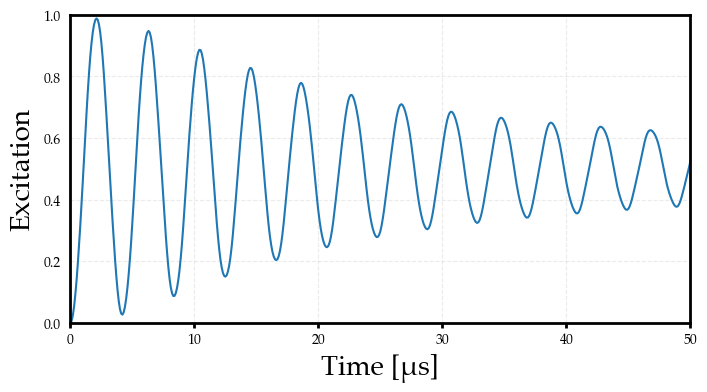

  7.272201 seconds (23.32 M allocations: 1.351 GiB, 5.69% gc time)


In [23]:
zero_stark_shift(C)  # sets all artificial Stark shifts to zero

# ions indexed by the string representing a particular level, return the associated ket
# also, an apostrophe after a ket will return the associated bra
ψi_ion = dm(C["S-1/2"])

# we'd like to look at a pretty hot ion, so we need to increase our mode dimension, which is set to N=10 by default
# here we set it to 100
mode.N = 100

ψi_mode = thermalstate(mode, 10)

ψi = ψi_ion ⊗ ψi_mode

tspan = 0:0.1:50
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)

ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
We can compare this result with the analytical expression which can be found in IonSim's `analytical` module:

In [30]:
?analytical.rabi_flop

```
rabi_flop(tspan, Ω::Real, η::Real, n̄::Real; s::Int=0) <br>
```

Single ion rabi flop. Returns: $\sum_{n=0}^∞ p_n sin^2(\Omega_n t)$ <br> with $\Omega_n = Ωe^{-η^2/2}η^s\sqrt{\frac{n!}{(n+s)!}}L_{n}^{s}(η^2)$ <br> where $s$ is the order of the (blue) sideband that we are driving and $L_{n}^{s}$ is the associated Laguerre polynomial. [ref](https://doi.org/10.1103/RevModPhys.75.281)


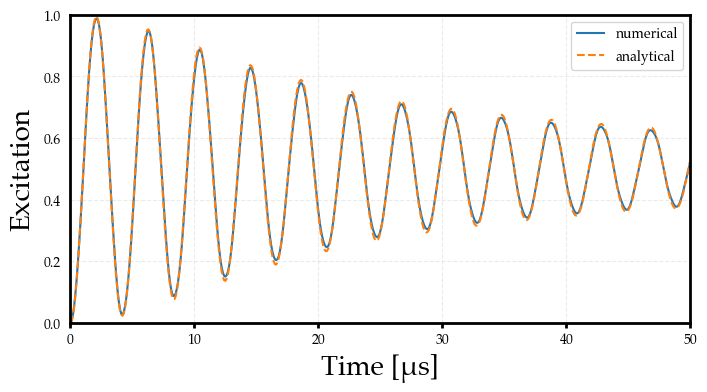

In [24]:
ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end], label="numerical")

η = get_η(mode, L, C)
plt.plot(tout, analytical.rabi_flop(tout, 1/4, η, 10), linestyle="--", label="analytical")

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
We see good, but not perfect agreement between the two curves. In fact, the majority of this discrepancy comes from off-resonant interaction with the first order sideband which the simulation captures but the analytical solution does not.

This can be confirmed by eliminating this off-resonant interaction in our simulation by setting they keyword argument `lamb_dicke_order` in the `hamiltonian` function to zero (by default, this is set to 1).

In [25]:
h = hamiltonian(T, lamb_dicke_order=0)  # set lamb_dicke_order here
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

  0.619270 seconds (824.26 k allocations: 347.098 MiB)


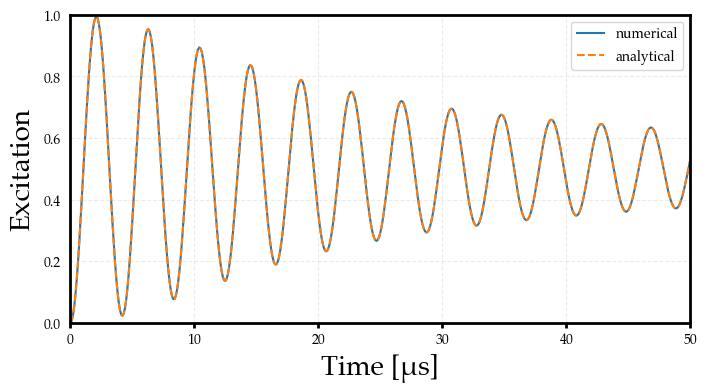

In [26]:
ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end], label="numerical")
η = get_η(mode, L, C)
plt.plot(tout, analytical.rabi_flop(tout, 1/4, η, 10), linestyle="--", label="analytical")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

Which givesa a much better agreement between the two curves.

At this point, it's worth explaining in more detail what we've just done. Conventionally, we would probably guess that setting the `lamb_dicke_order` to `n` would be equivalent to truncating the Taylor series expansion of the displacement operator $D(iη e^{iνt})$ after the $n^{th}$ order in η.

But this is not what IonSim does. Instead, it just drops all (Fock basis) matrix elements of $\langle m | D | n \rangle$ where $|m-n| > n$. 

All matrix elements of the operator are computed [analytically](https://doi.org/10.1103/PhysRev.177.1857). So, for example, even if we set `lamb_dicke_order=0`, we'll still retain the precise effect that the mode coupling has on the carrier transition -- as in the above example. 

### Sideband Transitions

Let's see some examples of driving sideband transitions:

  0.052846 seconds (1.30 M allocations: 40.075 MiB)


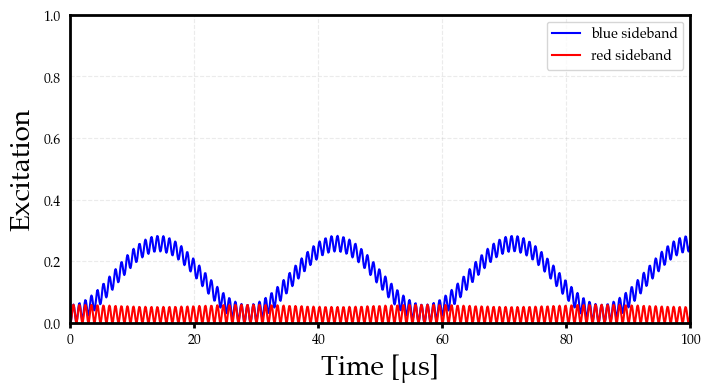

  0.052249 seconds (1.41 M allocations: 43.428 MiB)


In [27]:
tspan = 0:0.1:100
mode.N = 10  # set the motional dimension back to 10

L.Δ  = Δf + mode.ν  # tune laser frequency to blue sideband

h = hamiltonian(T)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)

L.Δ  = Δf - mode.ν  # tune laser frequency to red sideband

h = hamiltonian(T)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
The fast oscillations come from off-resonant excitation of the carrier transition. The slower oscillations are from population being driven back and forth between $|S_{-1/2}, n=0\rangle \leftrightarrow |D_{-1/2}, n=1 \rangle$. We only see these when detuning blue, because we start with the vibrational mode in the ground state (`fockstate(mode.basis, 0)`).

If we instead start out in `fockstate(mode.basis, 1)`:

  0.053634 seconds (1.50 M allocations: 46.197 MiB)


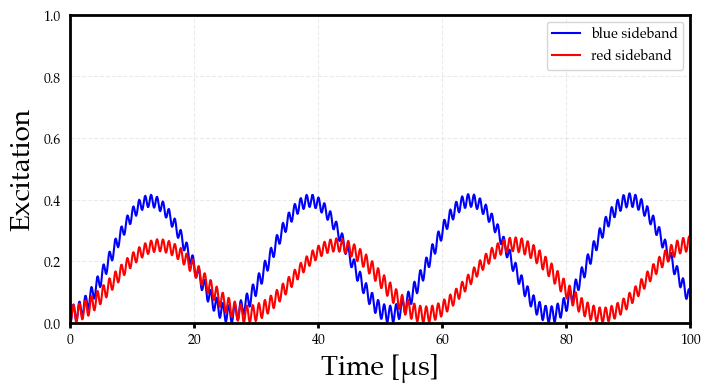

  0.064181 seconds (1.46 M allocations: 44.905 MiB)


In [28]:
L.Δ  = Δf + mode.ν  # tune laser frequency to blue sideband

h = hamiltonian(T)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

L.Δ  = Δf - mode.ν  # tune laser frequency to red sideband

h = hamiltonian(T, rwa_cutoff=1e7)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
The large detuning is coming almost entirely from an AC Stark shift off of the carrier transition.

We can confirm this by using they `rwa_cutoff` keyword in the `hamiltonian` function. Setting `rwa_cutoff=x`, will neglect all terms in the Hamiltonian that oscillate faster than `x`. *(Note: this doesn't apply to user-defined time-dependent parameters, which will be described in the next section).*

Since the vibrational mode frequency has been set to 1 MHz, if we set `rwa_cutoff=1e5`, we should neglect the carrier Stark shift in our simulation:

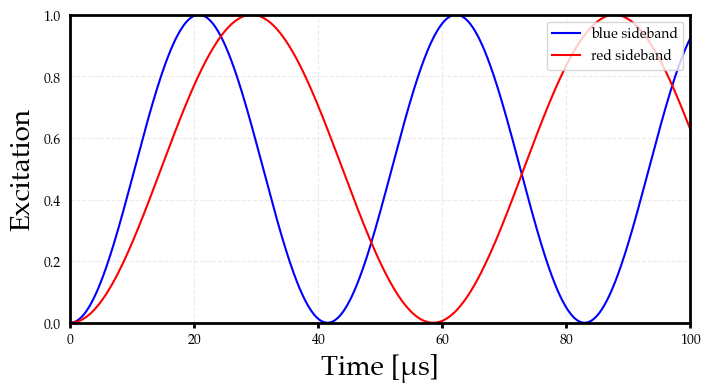

  0.001210 seconds (18.77 k allocations: 1.035 MiB)
  0.001284 seconds (14.93 k allocations: 939.938 KiB)


In [29]:
L.Δ  = Δf + mode.ν  # tune laser frequency to blue sideband

h = hamiltonian(T, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

L.Δ  = Δf - mode.ν  # tune laser frequency to red sideband

h = hamiltonian(T, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 1), h)

ex_blue = expect(ionprojector(T, "D-1/2"), sol_blue)
ex_red = expect(ionprojector(T, "D-1/2"), sol_red)
step = 1
plt.plot(tout[1:step:end], ex_blue[1:step:end], color="blue", label="blue sideband")
plt.plot(tout[1:step:end], ex_red[1:step:end], color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
A final note about the `rwa_cutoff`: 
If `hamiltonian` knows that you're not performing an RWA, it can do some optimization to reduce the number of internal functions that need to be evaluated, leading to faster performance. We can let it know that we're not performing an RWA by setting `rwa_cutoff=Inf` (this is the default value).

To reiterate: if you're not performing an RWA, then setting `rwa_cutoff` equal to `Inf`, rather than some arbitrarily large value, will lead to faster performance.

---

### Time-dependent parameters

All of the parameters denoted as time-dependent in the Hamiltonian equation at the start of this notebook can be set to arbitrary single-valued functions by the user. This can be useful for things like optimal control and modeling noise. 

Below we'll give a couple of examples of this.

---
First we note that the Stark shift-induced detuning of the BSB Rabi flop in the previous section can be compensated by adding an additional detuning to the laser:

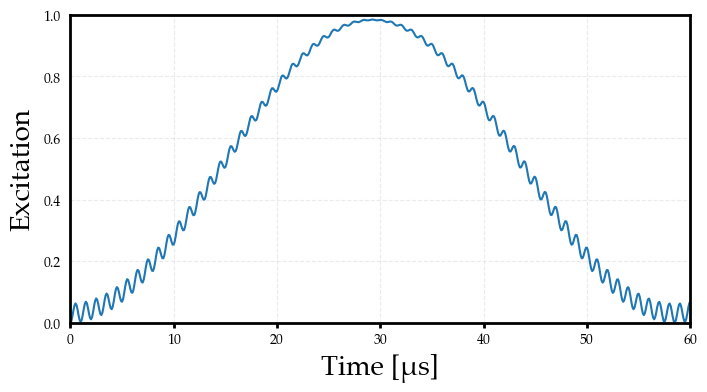

  0.036950 seconds (851.66 k allocations: 26.287 MiB)


In [30]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
However, we're still stuck with the off-resonant population oscillations from the carrier transition. It turns out we can eliminate these by ramping up the amplitude of the laser at the beginning of the simulation.

Such a ramp can be set with the `:E` field of the laser:

In [31]:
E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))  # get previous value of electric field strength

# Simple amplitude ramping function
function Ω(t)
    if t < 4
        return E * sin(2π * t / 16)^2
    end
    E
end;

L.E = Ω;

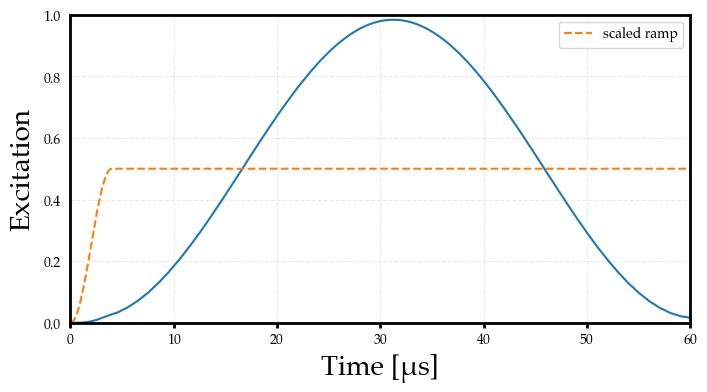

  0.064904 seconds (1.28 M allocations: 36.053 MiB)


In [32]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

---
To be a bit more succinct we can use a Julia *anonymous function*:

In [33]:
# To make things interesting let's also reduce the ramp time from 4 μs to 1 μs
L.E = t -> t < 1 ?  E * sin(2π * t / 4)^2 : E;

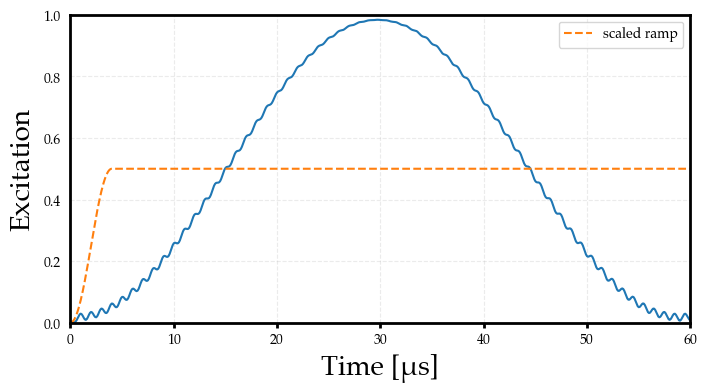

  0.061311 seconds (1.29 M allocations: 36.205 MiB)


In [34]:
L.Δ  = Δf + mode.ν - 31e3  # add additional detuning to BSB to compensate for carrier Stark shift

tspan = 0:0.1:60
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end])
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

Even with just a 1 μs ramp, we already see noticeable reduction of the fast oscillations.

---
As an example, of a time-dependent laser frequency we can simulate Rapid Adiabatic Passage or [RAP](https://doi.org/10.1080/09500340600741082), which can be used for robust preparation of the ion in an excited state.

In [41]:
# We'll linearly sweep through the laser's frequency from -150 kHz to +150 kHz detuned from the carrier transition
# in a time Tp

Tp = 150 # the length of time of the frequency chirp in μs
Δϕ = 2π * 150e-3  # this is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t

# We'll also ramp the Rabi frequency. Note I wasn't able to match the results from the paper when using a Gaussian profile, as they
# as described in the referenced paper
E = Efield_from_pi_time(6.5e-6, T, 1, 1, ("S-1/2", "D-1/2"))
tr = 33
function Ω(t)
    if t < tr
        return E * sin(2π * t / 4tr)^2
    elseif tr <= t <= 150 - tr
        return E
    elseif 150 - tr < t < 150
        return E * sin(2π * (t - 150) / 4tr)^2
    else
        return 0
    end
end
L.E = Ω;

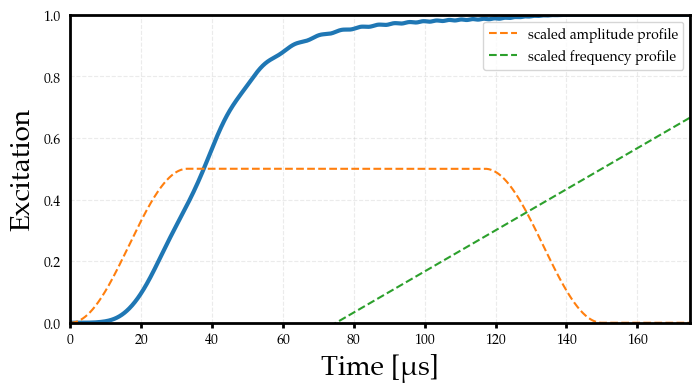

  0.125243 seconds (3.43 M allocations: 75.402 MiB, 18.93% gc time)


In [42]:
T.B = 2.9e-4  # Set the B-field to match the value in the reference
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))

L.Δ  = Δf  # set detuning back to carrier 

tspan = 0:0.1:175
h = hamiltonian(T)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)


ex = expect(ionprojector(T, "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], ex[1:step:end], lw=3)
plt.plot(tout, @.(L.E(tout) / 2E), linestyle="--", label="scaled amplitude profile")
plt.plot(tout, @.(L.ϕ(tout) / (2Δϕ * tout)), linestyle="--", label="scaled frequency profile")
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

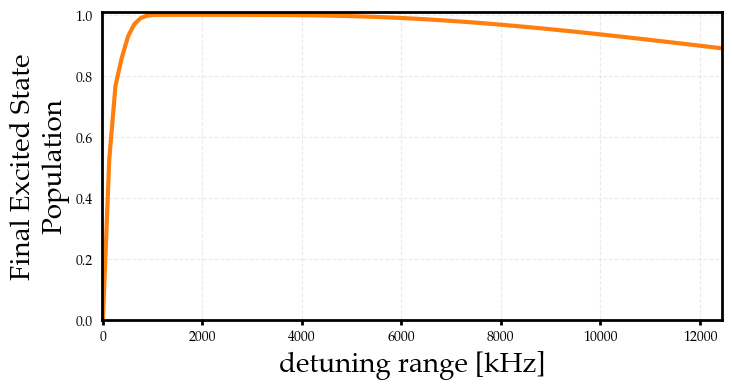

In [34]:
detuning_range = 2π*1e-6 .* collect(1e3:2e4:2e6)
pops = Vector{Float64}(undef, 0)
for Δϕ in detuning_range
    L.ϕ = t -> (-Δϕ/2 + (Δϕ / Tp) * t) * t
    h = hamiltonian(T)
    _, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(T, "S-1/2") ⊗ fockstate(mode, 0), h)
    push!(pops, real(expect(ionprojector(T, "D-1/2"), sol)[end]))
end
plt.plot(@.(detuning_range * 1e3), pops, lw=3, color="C1")
plt.xlim(-10, detuning_range[end] * 1e3)
plt.ylim(0, 1.01)
plt.ylabel("Final Excited State\nPopulation")
plt.xlabel("detuning range [kHz]");

In [35]:
L.ϕ = 0  # get rid of frequency chirp
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))  # and recompute the transition frequency
L.Δ = Δf;

### Noise

QuantumOptics has several solvers that can incorporate noise. Here are some examples for using these with IonSim. For more see the examples section. 

---
First we'll consider decoherence of the state $|\psi\rangle = |S\rangle + |D\rangle$ due to B-field fluctuations, which can be implemented by setting `T.δB` which has units of Tesla (we won't do it here, but this value can also be made time-dependent). 

In [36]:
using StochasticDiffEq

In [37]:
tspan = collect(0:10.:30000)
β = 1e-2
σ = √(2β)
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
w.dt = 0.1;

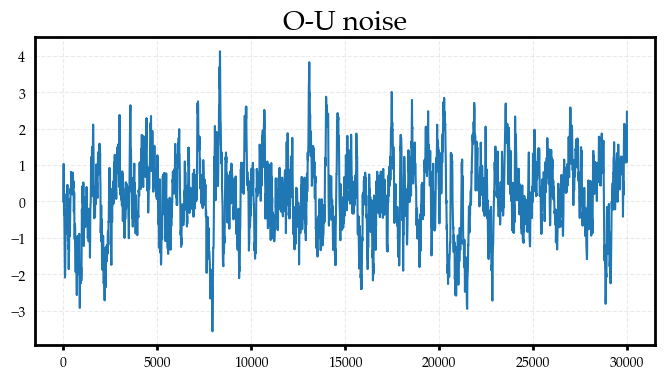

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9f805248d0>

In [38]:
plt.title("O-U noise")
warray = [w(t)[1] for t in tspan]
plt.plot(tspan, warray)

In [39]:
using DSP: periodogram

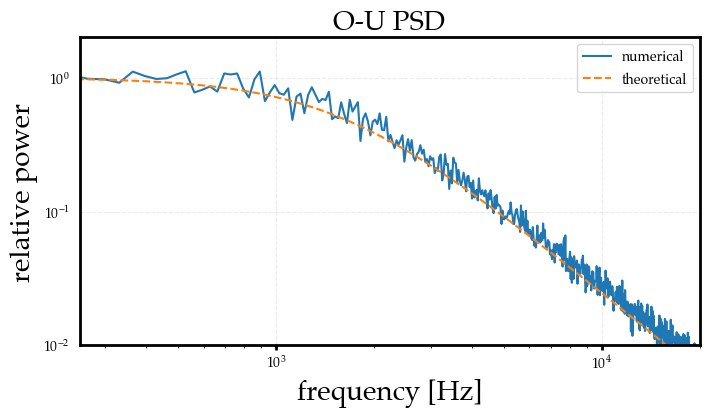

PyObject <matplotlib.legend.Legend object at 0x7fa0433ab550>

In [40]:
sample_rate = (length(tspan) - 1)/tspan[end]
pwarray = periodogram(warray, fs=sample_rate)
freqs = pwarray.freq
abs_freqs = freqs .* 1e6
powers = pwarray.power
N = 50
for i in 1:N-1
    w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
    w.dt = 0.1
    warray = [w(t)[1] for t in tspan]
    powers .+= periodogram(warray, fs=sample_rate).power
end
powers ./= powers[2]

plt.loglog(abs_freqs, powers, label="numerical")
ou_psd(f) = σ^2 / (β^2 + (2π * f)^2)
plt.loglog(abs_freqs, ou_psd.(freqs) ./ ou_psd(freqs[2]), color="C1", label="theoretical", ls="--")
plt.ylabel("relative power")
plt.xlabel("frequency [Hz]")
plt.title("O-U PSD")
plt.ylim(10e-3, 2)
plt.xlim(250, 2e4)
plt.legend()

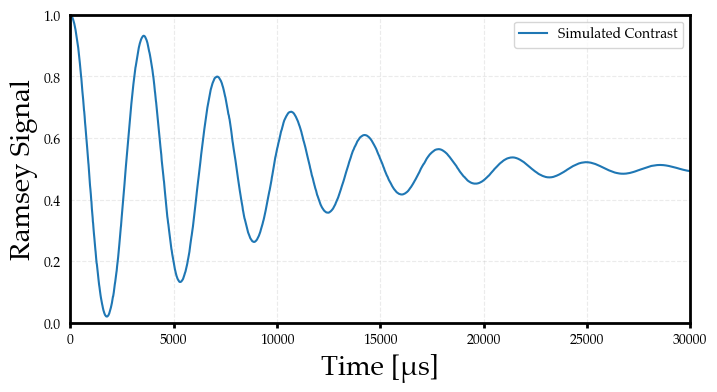

In [41]:
mode.N = 1  # we're not paying attention to the vibrational mode here, so we set its dimension to 1

# construct a zero operator
L.E = 0
T.δB = 5e-8
h = hamiltonian(T)

# let's work with a Δm=2 transition
T.configuration.ions[1].selected_level_structure = ["S-1/2", "D-5/2"]

# construct noise operator
T.δB = 5e-7
hs = hamiltonian(T)
hsvec = (t,ψ) -> [hs(t, ψ)]

ψi_ion = (ionstate(T, "S-1/2") + ionstate(T, "D-5/2"))/√2
ψi_mode = fockstate(mode, 0)
ψi = ψi_ion ⊗ ψi_mode

Ntraj = 100
ex = zero(tspan)

# iterate SDE solver Ntraj times and avergage results
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
for i in 1:Ntraj
    tout, sol = stochastic.schroedinger_dynamic(tspan, ψi, h, hsvec, noise=w,
    normalize_state=true, dt=0.1)
    ex .+= real.(expect(dm(ψi_ion) ⊗ one(mode), sol)) ./ Ntraj
end

step = 1
plt.plot(tspan[1:step:end], ex[1:step:end], color="C0", label="Simulated Contrast")
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.legend()
plt.ylabel("Ramsey Signal")
plt.xlabel("Time [μs]");

We can compare the same magnitude of B-field fluctuations for a white PSD. We could use the stochastic solver again, but instead let's use a Lindblad master equation solver:

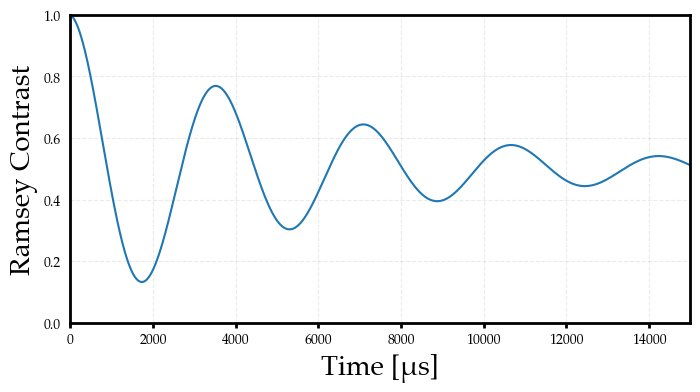

  3.361256 seconds (11.86 M allocations: 573.513 MiB, 4.51% gc time)


In [42]:
γ1 = hs(1.0, 0).data[1, 1]/40
γ2 = hs(1.0, 0).data[2, 2]/40

rates = 1/4π .* abs.([γ1, γ2])

hs1 = C["S-1/2"] ⊗ C["S-1/2"]' ⊗ one(mode)
hs2 = C["D-5/2"] ⊗ C["D-5/2"]' ⊗ one(mode)

tspan = collect(0:1.:15000)
@time tout, sol = timeevolution.master(tspan, dm(ψi), h(1.0, 0.0), [hs1, hs2], rates=rates)

ex = expect(dm(ψi_ion) ⊗ one(mode), sol)
step = 1
plt.plot(tspan[1:step:end], ex[1:step:end])
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.ylabel("Ramsey Contrast")
plt.xlabel("Time [μs]");

---
A brute force way to include shot-to-shot noise on a simulated parameter is to just run the simulation multiple times -- with the parameter pulled each time from some probability distribution -- and then average the results.

As an example, we consider fluctuations of the laser's electric field $E$ such that  $E \sim \mathcal{N}(\bar{E}, \delta E^2)$, then we should expect a Gaussian decay profile $e^{-t^2 / 2\tau^2}$ with: $1/\tau = \delta E\bigg(\frac{\partial\omega}{\partial E}\bigg)$.

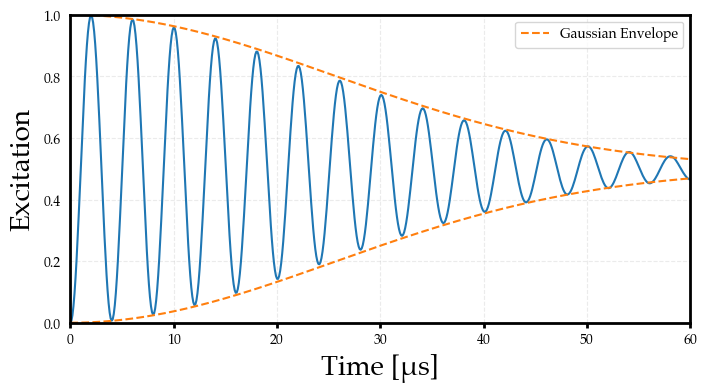

  1.696484 seconds (48.59 M allocations: 1.540 GiB, 11.89% gc time)


In [44]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))  #recompute the transition frequency
L.Δ = Δf

T.configuration.ions[1].selected_level_structure = ["S-1/2", "D-1/2"]
T.B = 4e-4
T.δB = 0
E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf
tspan = 0:0.1:60

# average over Ntraj runs
Ntraj = 500
δE = 0.025E
ex = zero(tspan)
ψi = ionstate(T, "S-1/2") ⊗ fockstate(mode, 0)
@time begin
    for i in 1:Ntraj
        ΔE = δE * randn()
        L.E = E + ΔE 
        h = hamiltonian(T)
        tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)
        ex .+= expect(ionprojector(T, "D-1/2"), sol) ./ Ntraj
    end
end

# compute expected τ
hz_per_E = 1 / Efield_from_rabi_frequency(1, ẑ, L, C, ("S-1/2", "D-1/2"))
τ_us = 1e6 / (2π * δE * hz_per_E)

step = 1
plt.plot(tspan[1:step:end], ex[1:step:end])
plt.plot(tspan, @.((1 + exp(-(tspan / (√2 * τ_us))^2))/2), color="C1", ls="--", label="Gaussian Envelope")
plt.plot(tspan, @.((1 - exp(-(tspan / (√2 * τ_us))^2))/2), color="C1", ls="--")
plt.xlim(tspan[1], tspan[end])
plt.ylim(0, 1)
plt.legend()
plt.ylabel("Excitation")
plt.xlabel("Time [μs]");

### Adding more than a single ion/ laser

Adding addtional lasers and ions to the system is straightforward. Here we'll see how that's done by modelling a [Molmer-Sorensen interaction](https://doi.org/10.1103/PhysRevA.62.022311), which can be used to entangle the electronic states of multiple ions and requires at least two laser tones and vibrational mode.

In [45]:
# Construct the system
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(); L2 = Laser() 
chain = LinearChain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/ion_configurations.jl:160


In [46]:
# Set the laser parameters
ϵ = 40e3
d = 80  # corrects for AC stark shift from single-photon coupling to sidebands
mode = T.configuration.vibrational_modes.z[1]
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L1.Δ = Δf + mode.ν + ϵ - d
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - mode.ν - ϵ + d
L2.k = ẑ
L2.ϵ = x̂

mode.N = 5
η = abs(get_η(mode, L1, C))
Ω1 = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω1, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω1, T, 2, 1, ("S-1/2", "D-1/2"));

In [47]:
ψi = ionstate(T, "S-1/2", "S-1/2") ⊗ fockstate(mode, 0);  # initial state

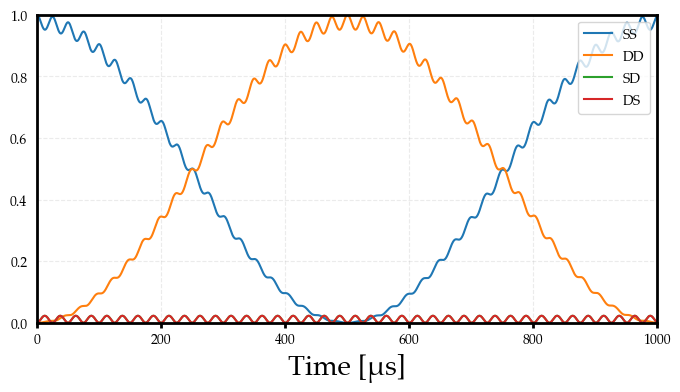

  0.025516 seconds (684.52 k allocations: 22.892 MiB)


In [49]:
# setup and run the Hamiltonian
h = hamiltonian(T, rwa_cutoff=5e5)
tspan = 0:0.25:1000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
plt.plot(tout[1:end], SS[1:end], label="SS")
plt.plot(tout[1:end], DD[1:end], label="DD")
plt.plot(tout[1:end], SD[1:end], label="SD")
plt.plot(tout[1:end], DS[1:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

We can compare this to the analytical result:

In [50]:
?analytical.two_ion_ms

```
two_ion_ms(tspan, Ω::Real, ν::Real, δ::Real, η::Real, n̄::Real)
```

[ref](https://doi.org/10.1103/PhysRevA.62.022311) <br> Assumes vibrational mode starts in a thermal state with: $\langle a^\dagger a\rangle = n̄$  and ions start in doubly ground state. Returns `(ρgg, ρee)`, the population in the doubly  ground and doubly excited state, respectively. $[Ω], [ν], [δ] = Hz$


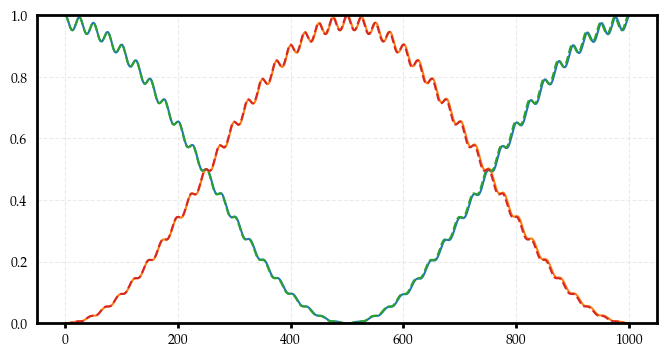

In [52]:
ex = analytical.two_ion_ms(tspan, 1e-6Ω1, 1e-6mode.ν, 1e-6mode.ν + 1e-6ϵ, η, 0)
plt.plot(tspan, SS)
plt.plot(tspan, DD)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.ylim(0, 1);

We can also see what happens when the vibrational mode starts out in a thermal state:

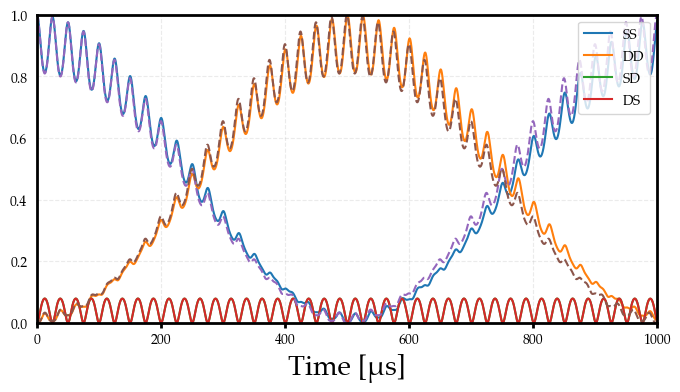

  0.710937 seconds (2.42 M allocations: 325.332 MiB, 26.27% gc time)


In [54]:
mode.N = 15
ρi = dm(ionstate(T, "S-1/2", "S-1/2")) ⊗ thermalstate(mode, 2)  # thermal state
h = hamiltonian(T, rwa_cutoff=5e5)
tspan = collect(0:0.25:1000)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ρi, h)

SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
plt.plot(tout[1:end], SS[1:end], label="SS")
plt.plot(tout[1:end], DD[1:end], label="DD")
plt.plot(tout[1:end], SD[1:end], label="SD")
plt.plot(tout[1:end], DS[1:end], label="DS")
ex = analytical.two_ion_ms(tspan, 1e-6Ω1, 1e-6mode.ν, 1e-6mode.ν + 1e-6ϵ, η, 2)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

There is some discrepancy because of the Lamb-Dicke approximation made in the analytical solution.

Adding more ions/lasers/modes is done the same way.

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/ion_configurations.jl:160


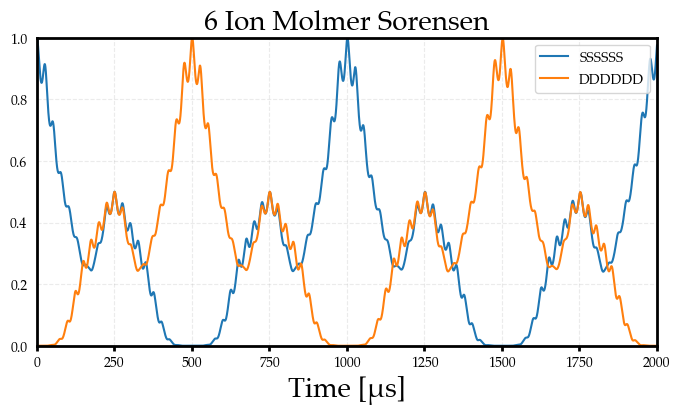

  1.316544 seconds (7.52 M allocations: 277.820 MiB, 14.34% gc time)


In [56]:
chain = LinearChain(ions=[C, C, C, C, C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2])
global_beam!(T, L1)  # set L1 to shine equally on all ions
global_beam!(T, L2)  # set L2 to shine equally on all ions
mode = T.configuration.vibrational_modes.z[1]
mode.N = 5
η = abs(get_η(mode, L1, C))
Ω2 = √(1e3 * ϵ) / η  
Efield_from_rabi_frequency!(Ω2, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω2, T, 2, 1, ("S-1/2", "D-1/2"))
ψi = ionstate(T, repeat(["S-1/2"], 6)...) ⊗ fockstate(mode, 0)

h = hamiltonian(T, rwa_cutoff=5e5)
tspan = 0:0.25:2000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

S = expect(ionprojector(T, repeat(["S-1/2"], 6)...), sol)
D = expect(ionprojector(T, repeat(["D-1/2"], 6)...), sol)
plt.plot(tout[1:end], S[1:end], label="SSSSSS")
plt.plot(tout[1:end], D[1:end], label="DDDDDD")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.title("6 Ion Molmer Sorensen")
plt.xlabel("Time [μs]");

### IonSim.PhysicalConstants

You can find some commonly used physical constants in `IonSim.PhysicalConstants`. They support all normal algebraic operations.

In [73]:
const pc = IonSim.PhysicalConstants;

In [74]:
pc.ħ

1.0545718e-34 [m²kg/s]

In [75]:
pc.c

2.99792458e8 [m/s]

In [76]:
print(pc.μB / pc.ħ, "\n")
print(pc.ħ + pc.c, "\n")
print(pc.α^pc.α, "\n")

8.794100069810324e10
2.99792458e8
0.9647321772836126
